<h1>1. Initial Setup</h1> 

In [ ]:
%pip install tensorflow opencv-python mathplotlib albumentations labelme

<h4>1.1 Import </h4>

In [4]:
import os
import cv2
import time
import uuid
import matplotlib.pyplot as plt 

In [37]:
main_folder='data'
img_path='data/images'

total_images=30

<h4>1.2 Capture WebCam Images </h4>

In [ ]:
capture=cv2.VideoCapture(0)

if capture.isOpened():

    for idx in range(total_images):
        print("Fetching Image - ",idx)

        ret,frame=capture.read()

        path=os.path.join(img_path,f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(path,frame)
        cv2.imshow('Sample',frame)
        time.sleep(0.5)

        if(cv2.waitKey(1) or 0xFF== ord('q')):
            break

capture.release()
cv2.destroyAllWindows()


<h4>1.3 Label The Faces present in Images </h4>

In [30]:
# This command opens the LabelMe GUI where you can label you Images
# In Edit > Rectangular Polygon, select it and mark the portion of the image as face 
# If the sample image dosent contain a face then skip it 
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Aditya\.labelmerc


<h1>2. Create Dataset</h1>

In [5]:
import tensorflow as tf
import numpy as np
import json

In [69]:
images=np.array([cv2.imread(os.path.join(img_path,i)) for i in os.listdir(img_path)])

In [72]:
np.random.shuffle(images)
images.shape

(215, 480, 640, 3)

[]

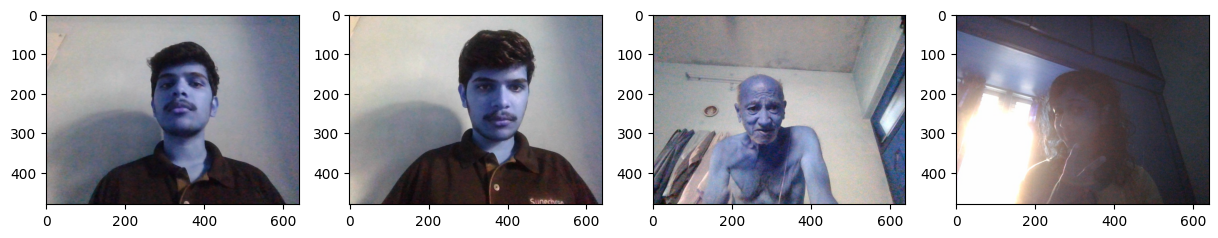

In [73]:
fig,ax = plt.subplots(ncols=4, figsize=(15,15))

for i,img in enumerate(images[:4]):
    ax[i].imshow(img)
plt.plot()

<h1>3. Partition Data</h1>

In [9]:
import math
import shutil

<h4>3.1 Shuffle images and split ranges

In [99]:
img=np.array(os.listdir(img_path))
np.random.shuffle(img)

In [100]:
l=len(img)
l_train=math.floor(l*0.7)
l_val=math.floor(l*0.9)


train_path="train"
test_path="test"
val_path="validation"

<h4>3.2 Segregate Images</h4>

In [101]:
for i in img[:l_train]:
    shutil.copyfile(os.path.join(img_path,i),os.path.join(train_path,'images',i))

In [104]:
for i in img[l_train:l_val]:
    shutil.copyfile(os.path.join(img_path,i),os.path.join(val_path,'images',i))

In [105]:
for i in img[l_val:]:
    shutil.copyfile(os.path.join(img_path,i),os.path.join(test_path,'images',i))

<h4>3.3 Segregate Labels</h4>

In [108]:
for folder in [train_path,val_path,test_path]:
    for images in os.listdir(os.path.join(folder,'images')):
        file=images.split('.')[0]+'.json'
        label_path=os.path.join(main_folder,'labels',file)
        if(os.path.exists(label_path)):
            new_path=os.path.join(folder,'labels',file)
            shutil.copyfile(label_path,new_path)

<h1>4. Apply Image Augmentation</h1>

In [6]:
import albumentations as alb

In [7]:
augmentation= alb.Compose([alb.RandomCrop(width=450, height=450),
                           alb.HorizontalFlip(p=0.5),
                           alb.RandomBrightnessContrast(p=0.2),
                           alb.RandomGamma(p=0.2),
                           alb.RGBShift(p=0.2),
                           alb.VerticalFlip(p=0.5)],
                           bbox_params=alb.BboxParams(format="albumentations",label_fields=['class_labels']))

We are applying image augmention on each image with the above filters(6)<br> so total number of resultant images are going to be (num_img*6)<br> Let us try applying on single image first

In [ ]:

img = cv2.imread(os.path.join(img_path,'f4c85058-a491-11ee-9e5d-70cf49366202.jpg'))
img.shape

In [167]:
with open(os.path.join('data', 'labels', 'f4c85058-a491-11ee-9e5d-70cf49366202.json'), 'r') as f:
    label = json.load(f)
label

{'version': '5.3.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[257.84530386740335, 60.44198895027626],
    [471.6574585635359, 346.0773480662984]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\Images\\f4c85058-a491-11ee-9e5d-70cf49366202.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRo

In [168]:
#Set the coordinates present in the labels.json file

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

# Normalising (Converting to Albumentation Format from Pascal VOC)
coords = list(np.divide(coords, [640,480,640,480]))

coords

[0.40288328729281775,
 0.12592081031307553,
 0.7369647790055248,
 0.7209944751381216]

By this point we have fetched the co-ordinates of our bounding box<br>Now we apply augmentation using the previously created pipeline

In [185]:
augmented = augmentation(image=img, bboxes=[coords], class_labels=['face'])
augmented

{'image': array([[[ 26,  14,  12],
         [ 26,   9,  13],
         [ 27,   8,  17],
         ...,
         [107,  99, 106],
         [104,  96, 103],
         [105,  93, 105]],
 
        [[ 24,  12,  10],
         [ 27,  12,  16],
         [ 28,  11,  20],
         ...,
         [106,  98, 108],
         [103,  95, 105],
         [101,  93, 104]],
 
        [[ 23,  13,  13],
         [ 30,  16,  20],
         [ 31,  17,  23],
         ...,
         [100,  94, 105],
         [100,  96, 107],
         [ 89,  90, 100]],
 
        ...,
 
        [[194, 189, 186],
         [193, 187, 182],
         [189, 183, 178],
         ...,
         [ 89,  96, 123],
         [ 82,  91, 118],
         [ 80,  94, 117]],
 
        [[191, 188, 184],
         [189, 186, 182],
         [187, 184, 180],
         ...,
         [ 87,  97, 121],
         [ 85,  97, 121],
         [ 76,  93, 114]],
 
        [[183, 182, 178],
         [184, 183, 179],
         [182, 181, 177],
         ...,
         [ 88,  99,

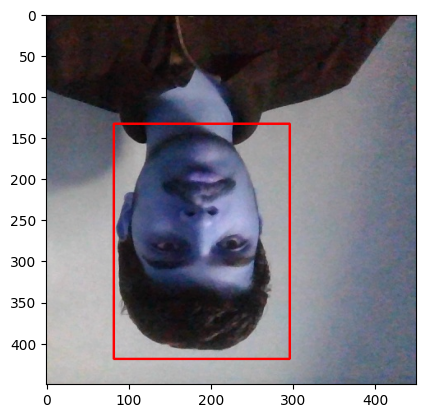

In [186]:
# Rescaling and displaying NEW augmented image with Bounding Box(Rectangular)

cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])
plt.show()

Now appy All the above procedures on all the images from Train. Test, Validation

In [9]:
for partition in ['train','validation','test']: 
    for image in os.listdir(os.path.join(partition, 'images')):
        img = cv2.imread(os.path.join(partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60): #This is the number of augmented images we want for each image
                augmented = augmentation(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('augmented', partition, 'images', f'{image.split(".")[0]}-{x}.jpg'), augmented['image'])

                newJSON = {}
                newJSON['image'] = image

                if os.path.exists(label_path) and len(augmented['bboxes'])!=0:
                    newJSON['bbox'] = augmented['bboxes'][0]
                    newJSON['class'] = 1
                else: 
                    newJSON['bbox'] = [0,0,0,0]
                    newJSON['class'] = 0 


                with open(os.path.join('augmented', partition, 'labels', f'{image.split(".")[0]}-{x}.json'), 'w') as f:
                    json.dump(newJSON, f)

        except Exception as e:
            print(e)

<h1>5. Combine Partion Dataset and Labels</h1>

In [2]:
def load_labels(path):

    with open(path, 'r') as f:
        label = json.load(f)

    return np.array([np.array([label['class']]),np.array(label['bbox'])],dtype='object')

In [3]:
def combine(path):

    img_path=os.path.join(path,'images')
    label_path=os.path.join(path,'labels')

    lst=[]

    for i in os.listdir(img_path):

        image=cv2.imread(os.path.join(img_path,i))
        resize=cv2.resize(image,(120,120))


        img=i.split('.')[0]
        label=load_labels(os.path.join(label_path,img+'.json'))

        lst.append(np.array([resize,label],dtype='object'))

    return np.array(lst)

In [8]:
main='augmented'

train=combine(os.path.join(main,'train'))
test=combine(os.path.join(main,'test'))
val=combine(os.path.join(main,'validation'))

In [9]:
print(len(train),len(test),len(val))

7200 1080 2040


In [34]:
np.random.shuffle(train)
np.random.shuffle(test)
np.random.shuffle(val)

Create training and testing Partitions for train, test, val.<br> 

In [35]:
x_train,y=zip(*train)
y1,y2=zip(*y)
x_train=tf.convert_to_tensor(x_train,dtype=tf.uint8)
y_train=[tf.convert_to_tensor(y1,dtype=tf.int64),tf.convert_to_tensor(y2,dtype=tf.float32)]

x_test,y=zip(*test)
y1,y2=zip(*y)
x_test=tf.convert_to_tensor(x_test,dtype=tf.uint8)
y_test=[tf.convert_to_tensor(y1,dtype=tf.int64),tf.convert_to_tensor(y2,dtype=tf.float32)]

x_val,y=zip(*val)
y1,y2=zip(*y)
x_val=tf.convert_to_tensor(x_val,dtype=tf.uint8)
y_val=[tf.convert_to_tensor(y1,dtype=tf.int64),tf.convert_to_tensor(y2,dtype=tf.float32)]


x_train = Tensor [Images] , dtype=uint8<br>
y_train = Tensor[ Tensor[Classification(0/1)] , Tensor[Co-ordinates]]

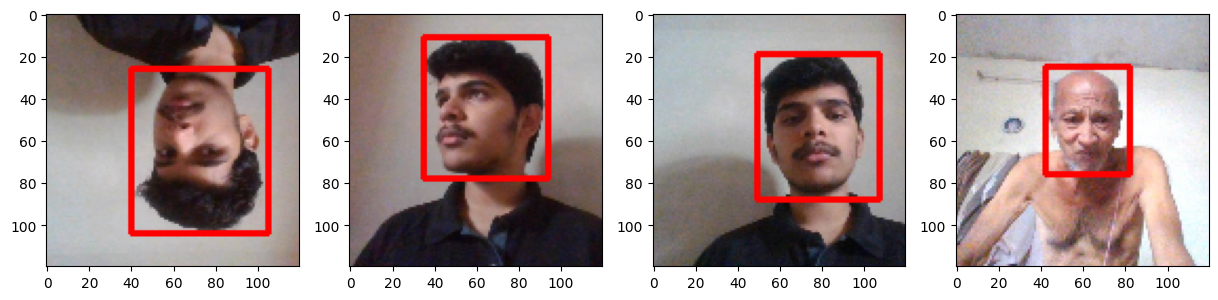

In [36]:
fig,ax = plt.subplots(ncols=4, figsize=(15,15))


for i in range(4):
    img=x_train[i]
    cor=y_train[i][1]

    cv2.rectangle(img,
                  tuple(np.multiply(cor[:2],[120,120]).astype(int)),
                  tuple(np.multiply(cor[2:],[120,120]).astype(int)),
                  (0,0,255), 2)
    
    ax[i].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

<h1>6. Build Deep Neural Network </h1>

In [82]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top=False)

<h4>6.1 Creating a Model with VGG16 architecture and Functional Layers</h4>

In [ ]:
def build_model():

  input_layer = Input(shape=(120,120,3))

  vgg=VGG16(include_top=False)(input_layer)

  flatten = GlobalMaxPooling2D()(vgg)

  hidden1 = Dense(2048, activation='relu')(flatten)
  predict1 = Dense(1, activation='sigmoid')(hidden1)

  flatten2 = GlobalMaxPooling2D()(vgg)
  hidden2 = Dense(2048, activation='relu')(flatten)
  predict2 = Dense(4, activation='sigmoid')(hidden2)

  model = Model(inputs=input_layer, outputs=[predict1,predict2])

  return model


In [ ]:
FaceDetection = build_model()
FaceDetection.summary()

<h4>6.2 Defining Optimizers and Losses</h4>

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
def bbox_loss(y_true, yhat):

    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
cls_loss = tf.keras.losses.BinaryCrossentropy()

<h4>6.3 Creating Class for Neural Network</h4>

In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(FaceDetection)

In [ ]:
model.compile(optimizer, cls_loss, bbox_loss)

<h4>6.4 Train Model</h4>

In [ ]:
hist = model.fit(x_train,y_train, epochs=50, validation_data=(x_val,y_val))

<h1>7. Plot Performance Metrics</h1>

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

<h1>7. Save The Model</h1>

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
FaceDetection.save('FaceDetection.h5')

<h4>We can also test the model on sample tset images</h4>

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(200,204):
    sample_image = x_val[idx].numpy()
    sample_coords = model.predict(np.expand_dims(sample_image,axis=0))[1][0]

    cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx-200].imshow(sample_image)

<h1>Run the model on Real Time Data (WebCam)</h1>

In [ ]:
facetracker=load_model('FaceDetection.h5',compile=False)



cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:451, 100:501,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized,axis=0))
    sample_coords = yhat[1][0]
    
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()